# Encoder nach Dennis:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

mpl.rcParams['figure.figsize'] = (15, 5)

np.random.seed(42)

### Trainingsdata Beispiel (mnist)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# add dim b/c of convolution
# scale data from [0,255] to [0,1]
x_train_cnn = x_train[:, :, :, np.newaxis] / 255.0
x_test_cnn = x_test[:, :, :, np.newaxis] / 255.0
x_train_cnn.shape

(60000, 28, 28, 1)

### Own Trainingsdata

In [3]:
spectogram_data = np.load("data\spectos.npy")
song_labels = np.load("data\song_labels.npy")
position_labels = np.load("data\position_labels.npy")

spectogram_data = spectogram_data[..., np.newaxis]
spectogram_data.shape

(7420, 128, 32, 1)

### Encoder:

In [4]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 32, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2),
], name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 16, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 64)         32832     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,082,146
Trainable params: 1,082,146
Non-tra

In [5]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    # we want this layer to have the same dimension as the first dense layer
    # so we can go "backwards" as we have gone "forwards"
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32*8*64),
    # reshape from a vector to a multidimensional array (image)
    tf.keras.layers.Reshape((32, 8, 64)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    # back to the 1 dimensional black/white image
    tf.keras.layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='leaky_relu'),
], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 16384)             1064960   
                                                                 
 reshape (Reshape)           (None, 32, 8, 64)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 16, 64)       65600     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 32, 32)      32800     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 32, 1)       513 

In [6]:
autoencoder = tf.keras.models.Model(encoder.input, decoder(encoder.output), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 16, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 64)         32832     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 

In [7]:
x_train_cnn.shape

(60000, 28, 28, 1)

In [8]:
spectogram_data.shape

(7420, 128, 32, 1)

In [9]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1, 2, 3]),
)

autoencoder.fit(
    #x=x_train_cnn,
    x=spectogram_data,
    # use the input as the target
    #y=x_train_cnn,
    y=spectogram_data,
    batch_size=200,
    shuffle=True,
    epochs=1,
)

38/38 [==============================] - 27s 695ms/step - loss: 532.9873


### Latent Space Repräsentation:

In [10]:
latent_represenation = encoder.predict(spectogram_data)
latent_represenation.shape

(7420, 2)

#### latent_representation ist ein zweidimensionales Array, das die Koordinaten aller Wavesets im Latent space enthält.

In [15]:
i = 2
print(latent_represenation[i])
latent_represenation.shape

[-4267.777 -2549.526]


(7420, 2)

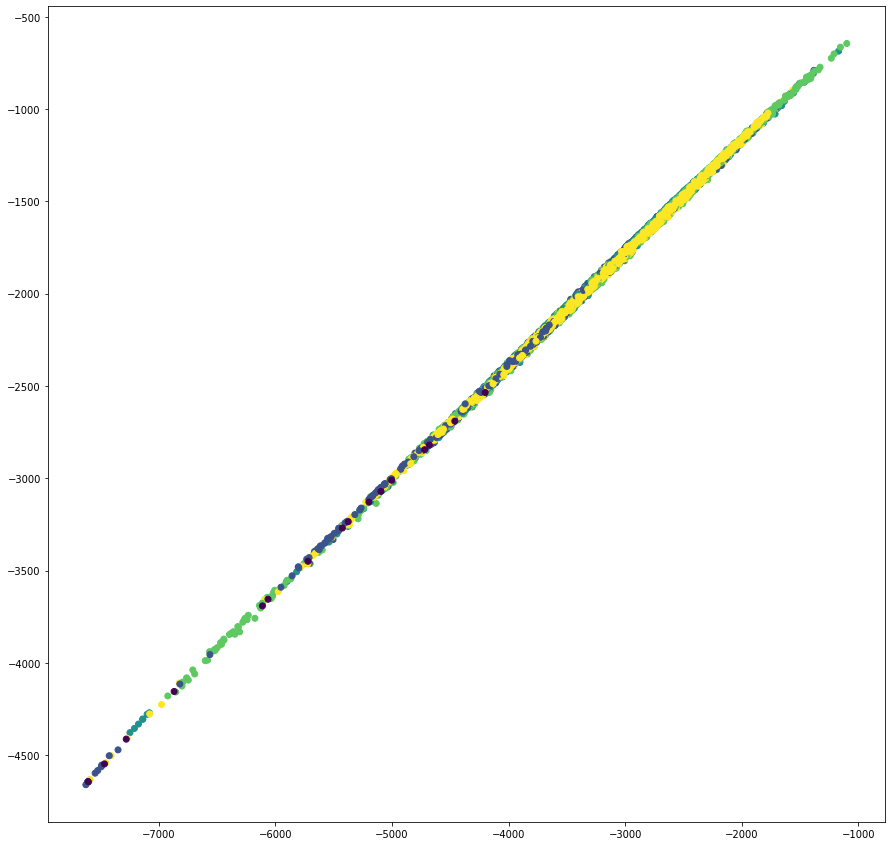

In [12]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_represenation[:, 0], latent_represenation[:, 1], c=position_labels)